# Train a Keras model from your ASL **skeleton image** dataset (A–Z folders)
Dataset structure expected:
```
dataset/AtoZ_3.1/
  A/ B/ C/ ... Z/
```

✅ **Requested behavior:** the **best model during training** is saved directly into `models/` (the same file your app loads).

Two label modes:
1. **`LABEL_MODE = 'groups'`** → 8 outputs (0..7) saved as `models/cnn8grps_rad1_model.h5` (matches your current app)
2. **`LABEL_MODE = 'letters'`** → 26 outputs saved as `models/cnn26letters_model.h5` (requires updating your app)

> Default is **groups**.

In [1]:
# ===== 1) Imports & Setup =====
import os, random
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


/Users/joshuaradzadlaon/Documents/vscode/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow: 2.20.0
GPU: []


## 2) Configure paths
Set `DATASET_DIR` to the folder that contains the A–Z folders.

In [2]:
# ===== 2) Paths & Config =====
PROJECT_ROOT = Path(".").resolve()

# ✅ Change this to your dataset path:
DATASET_DIR = PROJECT_ROOT / "dataset" / "AtoZ_3.1"

MODELS_DIR = PROJECT_ROOT / "models"
OUTPUTS_DIR = PROJECT_ROOT / "outputs"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = 400
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-3

# Choose label mode:
# - 'groups'  -> 8 outputs (0..7), matches your current app
# - 'letters' -> 26 outputs (A..Z), app must be updated to use it
LABEL_MODE = "groups"  # <-- keep this for your current app

# Your app currently feeds raw 0..255 pixel values (no normalization)
NORMALIZE = False

print("DATASET_DIR:", DATASET_DIR)
print("LABEL_MODE:", LABEL_MODE)


DATASET_DIR: /Users/joshuaradzadlaon/Documents/vscode/CSC173-DeepCV-Adlaon/dataset/AtoZ_3.1
LABEL_MODE: groups


## 3) Label mapping
### A) 8-group mapping (matches your app)
Groups used by your app mapping:
- `0`: A, E, M, N, S, T
- `1`: B, D, F, I, K, R, U, V, W
- `2`: C, O
- `3`: G, H
- `4`: L
- `5`: P, Q, Z
- `6`: X
- `7`: J, Y

### B) 26-letter mapping
A=0 ... Z=25.

In [3]:
# ===== 3) Label maps =====
LETTERS = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")

GROUP_TO_LETTERS = {
    0: list("AEMNST"),
    1: list("BDFIKRUVW"),
    2: list("CO"),
    3: list("GH"),
    4: list("L"),
    5: list("PQZ"),
    6: list("X"),
    7: list("JY"),
}

LETTER_TO_GROUP = {ch:g for g,ls in GROUP_TO_LETTERS.items() for ch in ls}
missing = [ch for ch in LETTERS if ch not in LETTER_TO_GROUP]
print("Missing letters in group map:", missing)  # should be []

LETTER_TO_INDEX = {ch:i for i,ch in enumerate(LETTERS)}


Missing letters in group map: []


## 4) Build dataframe (paths + labels)
Scans subfolders A..Z and collects image paths.

Supported file types: `.png .jpg .jpeg .bmp`

In [4]:
# ===== 4) Build dataframe =====
def build_df_from_letter_folders(root: Path):
    rows = []
    exts = {".png",".jpg",".jpeg",".bmp"}
    for ch in LETTERS:
        cls_dir = root / ch
        if not cls_dir.exists():
            continue
        for p in cls_dir.rglob("*"):
            if p.suffix.lower() in exts:
                rows.append({"image_path": str(p), "letter": ch})
    return pd.DataFrame(rows)

df = build_df_from_letter_folders(DATASET_DIR)

if len(df) == 0:
    raise FileNotFoundError(
        f"No images found. Check DATASET_DIR: {DATASET_DIR} "
        "and make sure it contains A/, B/, ... folders."
    )

if LABEL_MODE == "groups":
    df["label"] = df["letter"].map(LETTER_TO_GROUP).astype(int)
    NUM_CLASSES = 8
else:
    df["label"] = df["letter"].map(LETTER_TO_INDEX).astype(int)
    NUM_CLASSES = 26

print("Total images:", len(df))
print("Classes:", NUM_CLASSES)
df.head()


Total images: 4681
Classes: 8


,image_path,letter,label
0,/Users/joshuaradzadlaon/Documents/vscode/CSC17...,A,0
1,/Users/joshuaradzadlaon/Documents/vscode/CSC17...,A,0
2,/Users/joshuaradzadlaon/Documents/vscode/CSC17...,A,0
3,/Users/joshuaradzadlaon/Documents/vscode/CSC17...,A,0
4,/Users/joshuaradzadlaon/Documents/vscode/CSC17...,A,0


## 5) Train/Val/Test split (stratified)

In [5]:
# ===== 5) Split =====
train_df, temp_df = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df["label"]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=SEED, stratify=temp_df["label"]
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))


Train: 3744 Val: 468 Test: 469


## 6) tf.data pipeline
Loads images as **float32**, size **400×400×3**.
- `NORMALIZE=False` → 0..255 values (matches your app)
- `NORMALIZE=True` → 0..1 values (requires normalizing in app)

In [6]:
# ===== 6) tf.data =====
AUTOTUNE = tf.data.AUTOTUNE

def load_image(path, label):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), method="bilinear")
    img = tf.cast(img, tf.float32)
    if NORMALIZE:
        img = img / 255.0
    return img, label

def make_ds(df_in, shuffle=False):
    paths = df_in["image_path"].values
    labels = df_in["label"].values.astype(np.int32)
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(4096, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_df, shuffle=True)
val_ds   = make_ds(val_df, shuffle=False)
test_ds  = make_ds(test_df, shuffle=False)


## 7) Build model
Output layer size depends on `LABEL_MODE`:
- groups → 8
- letters → 26

In [7]:
# ===== 7) Model =====
def build_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=8):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="ASL_Skeleton_CNN")

model = build_cnn(num_classes=NUM_CLASSES)
model.summary()


Model: "ASL_Skeleton_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 400, 400, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 400, 400, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 200, 200, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 200, 200, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,472 (1.49 MB)

 Trainable params: 390,472 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

## 8) Train (best model saved directly into `models/`)
This will overwrite the model file each time validation accuracy improves.

- groups → `models/cnn8grps_rad1_model.h5`
- letters → `models/cnn26letters_model.h5`

In [8]:
# ===== 8) Train (BEST SAVED TO MODELS) =====
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# ✅ Save the best model straight to the file your app uses
if LABEL_MODE == "groups":
    best_model_path = MODELS_DIR / "cnn8grps_rad1_model.h5"
else:
    best_model_path = MODELS_DIR / "cnn26letters_model.h5"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=str(best_model_path),
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

print("Best model file (for your app):", best_model_path)


Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3772 - loss: 3.0698
Epoch 1: val_accuracy improved from None to 0.83333, saving model to /Users/joshuaradzadlaon/Documents/vscode/CSC173-DeepCV-Adlaon/models/cnn8grps_rad1_model.h5



Epoch 1: finished saving model to /Users/joshuaradzadlaon/Documents/vscode/CSC173-DeepCV-Adlaon/models/cnn8grps_rad1_model.h5
117/117 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.5224 - loss: 1.6104 - val_accuracy: 0.8333 - val_loss: 0.6580 - learning_rate: 0.0010
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7500 - loss: 0.6811
Epoch 2: val_accuracy improved from 0.83333 to 0.91667, saving model to /Users/joshuaradzadlaon/Documents/vscode/CSC173-DeepCV-Adlaon/models/cnn8grps_rad1_model.h5



Epoch 2: finished saving model to /Users/joshuaradzadlaon/Documents/vscode/CSC173-DeepCV-Adlaon/models/cnn8grps_rad1_model.h5
117/117 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.7823 - loss: 0.5975 - val_accuracy: 0.9167 - val_loss: 0.3443 - learning_rate: 0.0010
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8349 - loss: 0.4326
Epoch 3: val_accuracy improved from 0.91667 to 0.92735, saving model to /Users/joshuaradzadlaon/Documents/vscode/CSC173-DeepCV-Adlaon/models/cnn8grps_rad1_model.h5



Epoch 3: finished saving model to /Users/joshuaradzadlaon/Documents/vscode/CSC173-DeepCV-Adlaon/models/cnn8grps_rad1_model.h5
117/117 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8563 - loss: 0.3970 - val_accuracy: 0.9274 - val_loss: 0.2411 - learning_rate: 0.0010
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8945 - loss: 0.3079
Epoch 4: val_accuracy improved from 0.92735 to 0.97436, saving model to /Users/joshuaradzadlaon/Documents/vscode/CSC173-DeepCV-Adlaon/models/cnn8grps_rad1_model.h5



Epoch 4: finished saving model to /Users/joshuaradzadlaon/Documents/vscode/CSC173-DeepCV-Adlaon/models/cnn8grps_rad1_model.h5
117/117 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.9076 - loss: 0.2793 - val_accuracy: 0.9744 - val_loss: 0.1353 - learning_rate: 0.0010
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9103 - loss: 0.2577
Epoch 5: val_accuracy did not improve from 0.97436
117/117 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.8926 - loss: 0.3036 - val_accuracy: 0.9594 - val_loss: 0.1548 - learning_rate: 0.0010
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9403 - loss: 0.1960
Epoch 6: val_accuracy did not improve from 0.97436

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
117/117 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.9436 - loss: 0.1894 - val_accuracy: 0.9423 - val_loss: 0.1725 - learning_rate: 0.0010
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9481 - loss: 0.1539
Epoch 7: val_


Epoch 7: finished saving model to /Users/joshuaradzadlaon/Documents/vscode/CSC173-DeepCV-Adlaon/models/cnn8grps_rad1_model.h5
117/117 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9607 - loss: 0.1363 - val_accuracy: 0.9808 - val_loss: 0.0856 - learning_rate: 5.0000e-04
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9682 - loss: 0.1070
Epoch 8: val_accuracy did not improve from 0.98077
117/117 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9647 - loss: 0.1157 - val_accuracy: 0.9744 - val_loss: 0.1107 - learning_rate: 5.0000e-04
Epoch 9/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9732 - loss: 0.0964
Epoch 9: val_accuracy improved from 0.98077 to 0.98504, saving model to /Users/joshuaradzadlaon/Documents/vscode/CSC173-DeepCV-Adlaon/models/cnn8grps_rad1_model.h5



Epoch 9: finished saving model to /Users/joshuaradzadlaon/Documents/vscode/CSC173-DeepCV-Adlaon/models/cnn8grps_rad1_model.h5
117/117 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.9677 - loss: 0.1038 - val_accuracy: 0.9850 - val_loss: 0.0752 - learning_rate: 5.0000e-04
Epoch 10/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9767 - loss: 0.0978
Epoch 10: val_accuracy improved from 0.98504 to 0.99145, saving model to /Users/joshuaradzadlaon/Documents/vscode/CSC173-DeepCV-Adlaon/models/cnn8grps_rad1_model.h5



Epoch 10: finished saving model to /Users/joshuaradzadlaon/Documents/vscode/CSC173-DeepCV-Adlaon/models/cnn8grps_rad1_model.h5
117/117 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.9736 - loss: 0.0859 - val_accuracy: 0.9915 - val_loss: 0.0558 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 10.
Best model file (for your app): /Users/joshuaradzadlaon/Documents/vscode/CSC173-DeepCV-Adlaon/models/cnn8grps_rad1_model.h5


## 9) Curves

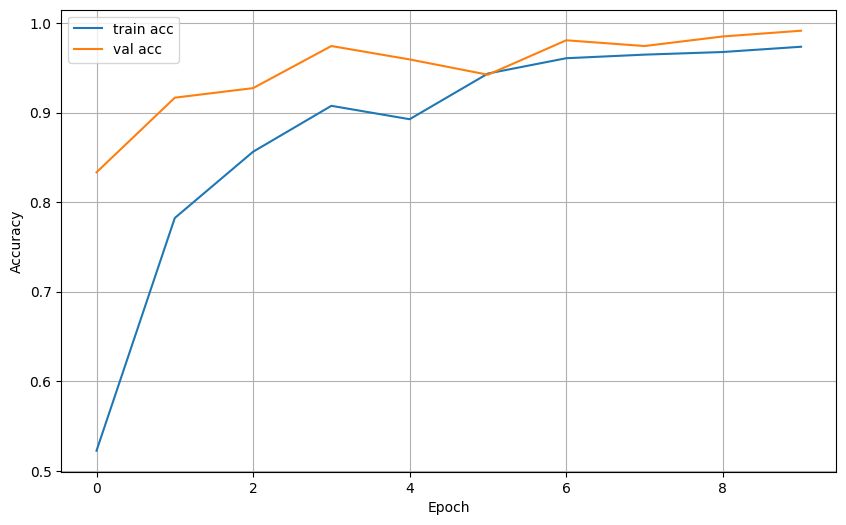

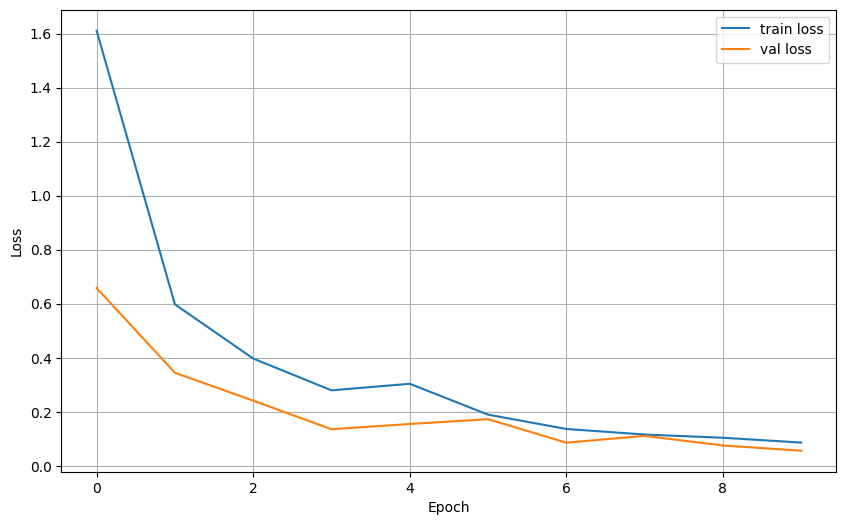

In [9]:
# ===== 9) Curves =====
hist = history.history

plt.figure(figsize=(10,6))
plt.plot(hist["accuracy"], label="train acc")
plt.plot(hist["val_accuracy"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(hist["loss"], label="train loss")
plt.plot(hist["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## 10) Evaluate + confusion matrix

In [ ]:
# ===== 13A) Predict with the reloaded (best) model =====
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, precision_recall_fscore_support
)
from sklearn.metrics import top_k_accuracy_score

# Ground truth in the same order as test_ds (shuffle=False) ✅
y_true = test_df["label"].values.astype(int)

# Predict probabilities
y_prob_best = reloaded.predict(test_ds, verbose=0)
y_pred_best = np.argmax(y_prob_best, axis=1)

# Helper: pretty class names (8 groups or 26 letters)
if LABEL_MODE == "groups":
    class_names = [f"{g}: {''.join(GROUP_TO_LETTERS[g])}" for g in range(NUM_CLASSES)]
else:
    class_names = LETTERS[:NUM_CLASSES]
print("Classes:", class_names)


,Metric,Value
0,Accuracy,0.991471
1,Balanced Accuracy,0.990928
2,F1 (Macro),0.993835
3,F1 (Weighted),0.991444
4,Top-2 Accuracy,0.995736
5,Top-3 Accuracy,0.995736


## 11) Reload the saved best model (sanity check)

In [11]:
# ===== 11) Reload saved best model =====
reloaded = keras.models.load_model(str(best_model_path))
print("Reloaded model from:", best_model_path)
print("Output shape:", reloaded.output_shape)


Reloaded model from: /Users/joshuaradzadlaon/Documents/vscode/CSC173-DeepCV-Adlaon/models/cnn8grps_rad1_model.h5
Output shape: (None, 8)


## 12) App-style predict sanity check

In [12]:
# ===== 12) App-style predict sanity check =====
sample_path = test_df.iloc[0]["image_path"]
img = cv2.imread(sample_path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
x = img.reshape(1, IMG_SIZE, IMG_SIZE, 3).astype(np.float32)
if NORMALIZE:
    x = x / 255.0

prob = reloaded.predict(x, verbose=0)[0]
print("Sample:", sample_path)
print("True label:", int(test_df.iloc[0]["label"]))
print("Pred label:", int(np.argmax(prob)))
print("Prob:", prob)


Sample: /Users/joshuaradzadlaon/Documents/vscode/CSC173-DeepCV-Adlaon/dataset/AtoZ_3.1/N/45.jpg
True label: 0
Pred label: 0
Prob: [9.9891448e-01 1.0704371e-03 8.6064055e-08 7.6192239e-16 8.7337071e-07
 7.9804902e-13 1.3994057e-05 2.0293555e-07]
